# Simulations with VF

+ Start with priors
+ Random outcomes with demand
+ See what happens with optimal pricing, profit and learning
+ Put particular attention into rolling standard deviation of price

Models: 2018-10-1vfi_dict.dill

In [81]:
%matplotlib inline

import matplotlib.pyplot as plt
import dill
import numpy as np
import pandas as pd
#file_n = "2018-10-1vfi_dict.dill"  
file_n = "2018-10-4vfi_dict.dill"
with open('../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)
    
    
import sys
sys.path.append('../')
import src

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']



lambdas_ext = src.generate_simplex_3dims(n_per_dim=15) #15 should watch value f iteration
print(lambdas_ext.shape)

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)

(120, 3)


In [66]:
# Demand realization
def draw_true_log_dmd(price, β, σϵ):
    """
    Draws from true demand data generating process
    
    price: level price, NOT log
    σϵ: standard deviation of the error/noise
    """
    return np.random.normal(loc=src.const.α + β*np.log(price), scale=σϵ)

new_dmd = 3.2
old_lambdas = np.array([0.2, 0.6, 0.2])
src.update_lambdas(new_dmd, src.dmd_transition_fs, old_lambdas,
                   action=1.2, old_state=1.2)

array([0.00191041, 0.54878312, 0.44930647])

In [103]:

def one_run(lambda0=np.array([0.4, 0.4, 0.2]),
                             true_beta=src.betas_transition[2],
                             dmd_σϵ=src.const.σ_ɛ, 周期=40):
    current_lambdas = lambda0
    d = {}
    d['level_prices'] = []
    d['log_dmd'] = []
    d['valueF'] = []
    d['lambda1'] = []
    d['lambda2'] = []
    d['lambda3'] = []


    for t in range(周期):
        d['lambda1'].append(current_lambdas[0])
        d['lambda2'].append(current_lambdas[1])
        d['lambda3'].append(current_lambdas[2])
        d['valueF'].append(valueF(current_lambdas[:2])[0])

        #0. Choose optimal price (last action of t-1)
        level_price = policyF(current_lambdas[:2]) #Check: Is this correctly defined with the first two elements?
        d['level_prices'].append(level_price[0])

        #1. Demand happens
        log_dmd = draw_true_log_dmd(level_price, true_beta, dmd_σε)
        d['log_dmd'].append(log_dmd[0])

        #2. lambda updates: log_dmd: Yes, level_price: Yes
        new_lambdas = src.update_lambdas(log_dmd, src.dmd_transition_fs, current_lambdas,
                       action=level_price, old_state=1.2)

        current_lambdas = new_lambdas
            
    return pd.DataFrame(d)

def many_runs(total_runs, **kwargs):
    dfs = []
    for run in range(total_runs):
        df = one_run(**kwargs)
        df['run'] = run
        dfs.append(df)
        
    return pd.concat(dfs, axis=0)

todo = many_runs(10, 周期=250)
        
        

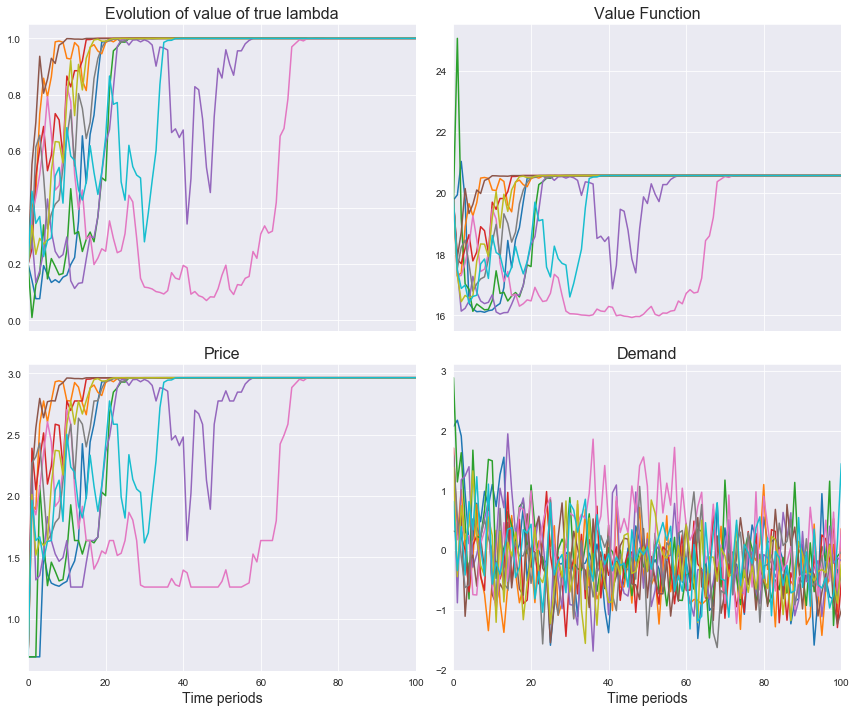

In [106]:
import seaborn as sns
sns.set_style("darkgrid")
df = one_run()
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

xmax = 100
ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
for run in todo.run.unique():
    df = todo[todo.run == run]
    
    df.lambda3.plot(ax=ax1)
    ax1.set_xlabel("Time periods", size=14)
    ax1.set_title("Evolution of value of true lambda", size=16)

    df.valueF.plot(ax=ax2)
    ax2.set_xlabel("Time periods", size=14)
    ax2.set_title("Value Function", size=16)

    df.level_prices.plot(ax=ax3)
    ax3.set_xlabel("Time periods", size=14)
    ax3.set_title("Price", size=16)

    df.log_dmd.plot(ax=ax4)
    ax4.set_xlabel("Time periods", size=14)
    ax4.set_title("Demand", size=16)
    
    ax4.set_xlim(0, xmax)
    fig.tight_layout()

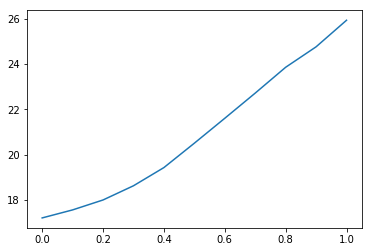

In [5]:
lambdas_selected = np.array([[0.0, 0.5, 0.5],
                    [0.1, 0.5, 0.4],
                    [0.2, 0.5, 0.3],
                    [0.3, 0.5, 0.2],
                    [0.4, 0.5, 0.1],
                    [0.5, 0.4, 0.1],
                    [0.6, 0.3, 0.1],
                    [0.7, 0.2, 0.1],
                    [0.8, 0.1, 0.1],
                    [0.9, 0.1, 0.0],
                    [1.0, 0.0, 0.0]])


valuef_values = valueF(lambdas_selected[:, 0:2])

fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, 1, num=11), valuef_values)